In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# PyTorch Geometric modules.
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# For graph generation.
import networkx as nx

# For visualization.
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility.
torch.manual_seed(42)
np.random.seed(42)


## Sample example graph

We create three communities of nodes, where we have the probability $P(E(x_i,x_j))=0.5$ if $x_i,x_j$ is in the same community otherwise we have $P(E(x_i,x_j))=0.005$


In [20]:
sizes = [30,30,40]
num_nodes = sum(sizes)

p = [[0.2 if i == j else 0.001 for j in range(3)] for i in range(3)]

G = nx.stochastic_block_model(sizes, p)

edge_list = list(G.edges())
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Since the graph is undirected, add reverse edges.
row, col = edge_index
edge_index = torch.cat([edge_index, torch.stack([col, row], dim=0)], dim=1)
print("Edge Index shape:", edge_index.shape)



Edge Index shape: torch.Size([2, 702])


In [21]:
# number of nodes
print(len(G.nodes()))
# number of edges
print(len(G.edges()))


100
351


# Creating feature vector

For each node now we create a feature vector now, this is just randomply initilized now with a dimension of 4

We also seperate the labels now such that we can plot it later, but this is unsupervised learning here!

In [22]:

x = torch.randn(num_nodes, 4, dtype=torch.float)

labels = [G.nodes[i]['block'] for i in range(num_nodes)]
labels = torch.tensor(labels, dtype=torch.long)

# PyG Data object.
data = Data(x=x, edge_index=edge_index)
print(data)



Data(x=[100, 4], edge_index=[2, 702])


# Createing the GCN (Graph Convolutional Network)

Creates two GCN Layers and forward passes them with a ReLU between them 

Create the model where we have the foolowing matrxi calcs:

- IC: 4
- HC: 16
- OC: 2





In [23]:
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        """
        Args:
            in_channels (int): Dimension of input node features.
            hidden_channels (int): Hidden layer dimension.
            out_channels (int): Output embedding dimension.
        """
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        # First GCN layer with ReLU activation.
        x = self.conv1(x, edge_index) # (num_nodes, IC) --> (num_nodes, HC)
        x = F.relu(x)  # (num_nodes, HC) --> (num_nodes, HC)
        # Second GCN layer produces the final embeddings.
        x = self.conv2(x, edge_index) # (num_nodes, HC) --> (num_nodes, OC)
        return x

# Instantiate the model.
model = SimpleGCN(in_channels=4, hidden_channels=16, out_channels=2)
print("Model:")
print(model)


Model:
SimpleGCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 2)
)


## Contrastive Pairs

- Begin with sampling contrastive pairs where we define
    - Potive samples are nodes that are neigbours
    - Negative samples are nodes that are more fair away then just being neighbours 


## Contrastive Loss
- Here we want to have **high** similirty between anchor and positive pairs and **low** similiart between anchor and negative pairs

Where we then minimize 

$$max(0,\text{margin - \text{cos}(a,p)-\text{cos}(a,n)})$$


In [24]:
def sample_contrastive_pairs(edge_index, num_nodes, num_negatives=3):
    """
    For each node, sample one positive (a neighbor) and a few negatives (non-neighbors).

    Returns:
      anchors: list of anchor node indices.
      positives: list of positive node indices (neighbors).
      negatives: list of lists; negatives[i] is a list of negative indices for anchor i.
    """
    # Build a dictionary mapping each node to its set of neighbors.
    neighbors = {i: set() for i in range(num_nodes)} 
    edge_index_np = edge_index.cpu().numpy() # gets al deges
    for src, dst in zip(edge_index_np[0], edge_index_np[1]):
        neighbors[src].add(dst)
    
    anchors, positives, negatives = [], [], []
    for i in range(num_nodes):
        if len(neighbors[i]) == 0:
            continue  # Skip isolated nodes.
        # Randomly choose one positive sample from neighbors.
        pos_candidates = list(neighbors[i])
        pos_sample = pos_candidates[torch.randint(len(pos_candidates), (1,)).item()]
        
        # Negative candidates: nodes that are not neighbors and not the anchor.
        neg_candidates = list(set(range(num_nodes)) - neighbors[i] - {i})
        if len(neg_candidates) >= num_negatives:
            neg_sample = [neg_candidates[idx] for idx in torch.randperm(len(neg_candidates))[:num_negatives]]
            anchors.append(i)
            positives.append(pos_sample)
            negatives.append(neg_sample)
    return anchors, positives, negatives

def contrastive_loss(embeddings, anchors, positives, negatives, margin=0.5):
    """
    Computes a margin-based contrastive loss.
    
    For each anchor:
      loss = mean( ReLU( margin - (sim(anchor, positive) - sim(anchor, negative)) ) )
    where sim is cosine similarity.
    """
    loss_all = []
    for i, pos_idx, neg_idxs in zip(anchors, positives, negatives):
        anchor_emb = embeddings[i]
        pos_emb = embeddings[pos_idx]
        pos_sim = F.cosine_similarity(anchor_emb.unsqueeze(0), pos_emb.unsqueeze(0))
        neg_embs = embeddings[neg_idxs]
        neg_sim = F.cosine_similarity(anchor_emb.unsqueeze(0), neg_embs)
        loss_per_negative = F.relu(margin - (pos_sim - neg_sim))
        loss_all.append(loss_per_negative.mean())
    if loss_all:
        return torch.stack(loss_all).mean()
    else:
        return torch.tensor(0.0)


In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
num_epochs = 1001

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index)
    
    # Sample contrastive pairs.
    anchors, positives, negatives = sample_contrastive_pairs(data.edge_index, num_nodes, num_negatives=30)
    
    # Compute the contrastive loss.
    loss = contrastive_loss(embeddings, anchors, positives, negatives, margin=0.5)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")


Epoch 000, Loss: 0.4482
Epoch 020, Loss: 0.2840
Epoch 040, Loss: 0.2266
Epoch 060, Loss: 0.2202
Epoch 080, Loss: 0.2026
Epoch 100, Loss: 0.2015
Epoch 120, Loss: 0.2099
Epoch 140, Loss: 0.1704
Epoch 160, Loss: 0.1793
Epoch 180, Loss: 0.1538
Epoch 200, Loss: 0.1593
Epoch 220, Loss: 0.1505
Epoch 240, Loss: 0.1415
Epoch 260, Loss: 0.1333
Epoch 280, Loss: 0.1425
Epoch 300, Loss: 0.1406
Epoch 320, Loss: 0.1234
Epoch 340, Loss: 0.1301
Epoch 360, Loss: 0.1382
Epoch 380, Loss: 0.1476
Epoch 400, Loss: 0.1313
Epoch 420, Loss: 0.1245
Epoch 440, Loss: 0.1246
Epoch 460, Loss: 0.1327
Epoch 480, Loss: 0.1256
Epoch 500, Loss: 0.1300
Epoch 520, Loss: 0.1311
Epoch 540, Loss: 0.1513
Epoch 560, Loss: 0.1404
Epoch 580, Loss: 0.1428
Epoch 600, Loss: 0.1403
Epoch 620, Loss: 0.1279
Epoch 640, Loss: 0.1444
Epoch 660, Loss: 0.1301
Epoch 680, Loss: 0.1245
Epoch 700, Loss: 0.1212
Epoch 720, Loss: 0.1288
Epoch 740, Loss: 0.1261
Epoch 760, Loss: 0.1314
Epoch 780, Loss: 0.1284
Epoch 800, Loss: 0.1258
Epoch 820, Loss:

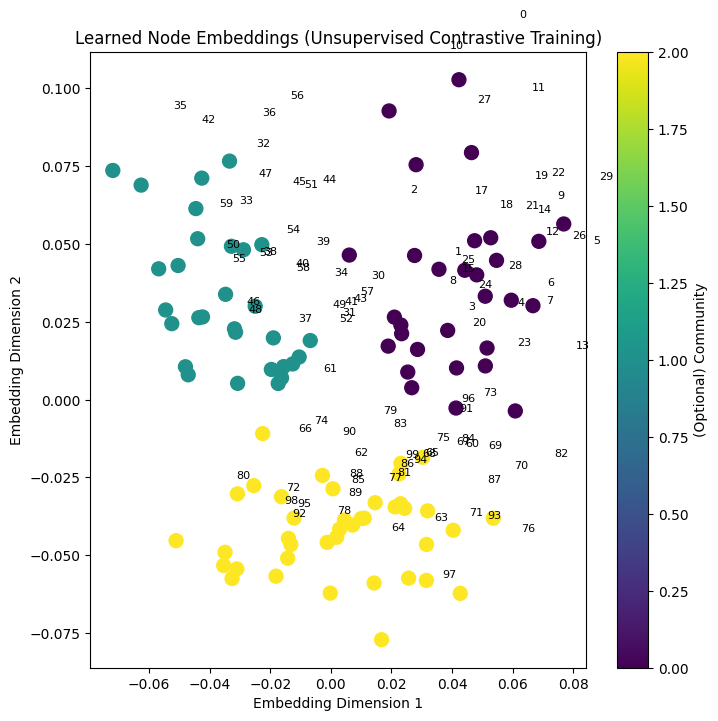

In [26]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

emb_np = embeddings.detach().cpu().numpy()

# (Optional) Use the saved community labels for coloring the plot.
# These labels were generated in Cell 4 for visualization only.
colors = None  # If you prefer a single color for all nodes, set colors = 'skyblue'
if 'labels' in globals():
    colors = labels.numpy()

plt.figure(figsize=(8, 8))
scatter = plt.scatter(emb_np[:, 0], emb_np[:, 1], s=100, c=colors, cmap='viridis')
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Learned Node Embeddings (Unsupervised Contrastive Training)")
if colors is not None:
    plt.colorbar(scatter, label='(Optional) Community')
# Annotate node indices.
for i, (x_coord, y_coord) in enumerate(emb_np):
    plt.text(x_coord + 0.02, y_coord + 0.02, str(i), fontsize=8)
plt.show()
